In [7]:
!pip install lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import joblib

In [9]:
# ---------------------------
# 1. Load and Prepare Data
# ---------------------------

# Load CSV without parsing dates
df = pd.read_csv("features_target.csv")

# Drop unnecessary column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Create synthetic date index
df['date'] = pd.date_range(start='2000-01-01', periods=len(df), freq='D')
df.set_index('date', inplace=True)

# Print basic info
print("Data shape:", df.shape)
print(df.head())

Data shape: (2264, 30)
              SP500  SP500 Log Returns  SP500 30 Day Volatility  \
date                                                              
2000-01-01  1070.25           0.009369                28.510976   
2000-01-02  1077.96           0.007178                28.462814   
2000-01-03  1078.75           0.000733                28.041079   
2000-01-04  1095.34           0.015262                28.157439   
2000-01-05  1095.17          -0.000155                28.338036   

            SPX Put Call Ratio  SPX Put Volume  SPX Call Volume  \
date                                                              
2000-01-01                1.12        280436.0         251021.0   
2000-01-02                1.20        376805.0         315132.0   
2000-01-03                1.49        421390.0         283127.0   
2000-01-04                1.25        652349.0         519892.0   
2000-01-05                1.01        475499.0         469171.0   

            Total SPX Options Volume 

In [11]:
# ---------------------------
# 2. Define Features & Target
# ---------------------------

# Predict next day's volatility using today's features
y = df['SP500 30 Day Volatility'].shift(-1)
X = df.drop(columns=['SP500 30 Day Volatility'])

# Drop the last row (NaN target)
X = X[:-1]
y = y[:-1]


In [12]:
# ---------------------------
# 3. Train/Test Split (time-based)
# ---------------------------

split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [15]:
# ---------------------------
# 4. Train LightGBM Model
# ---------------------------

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=31,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l1',
)

# ---------------------------
# 5. Evaluation
# ---------------------------

y_pred = model.predict(X_test)

def evaluate(y_true, y_pred):
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}")

evaluate(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7161
[LightGBM] [Info] Number of data points in the train set: 1810, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 26.775378
MAE:  2.0794
RMSE: 6.7767
R²:   0.8912


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


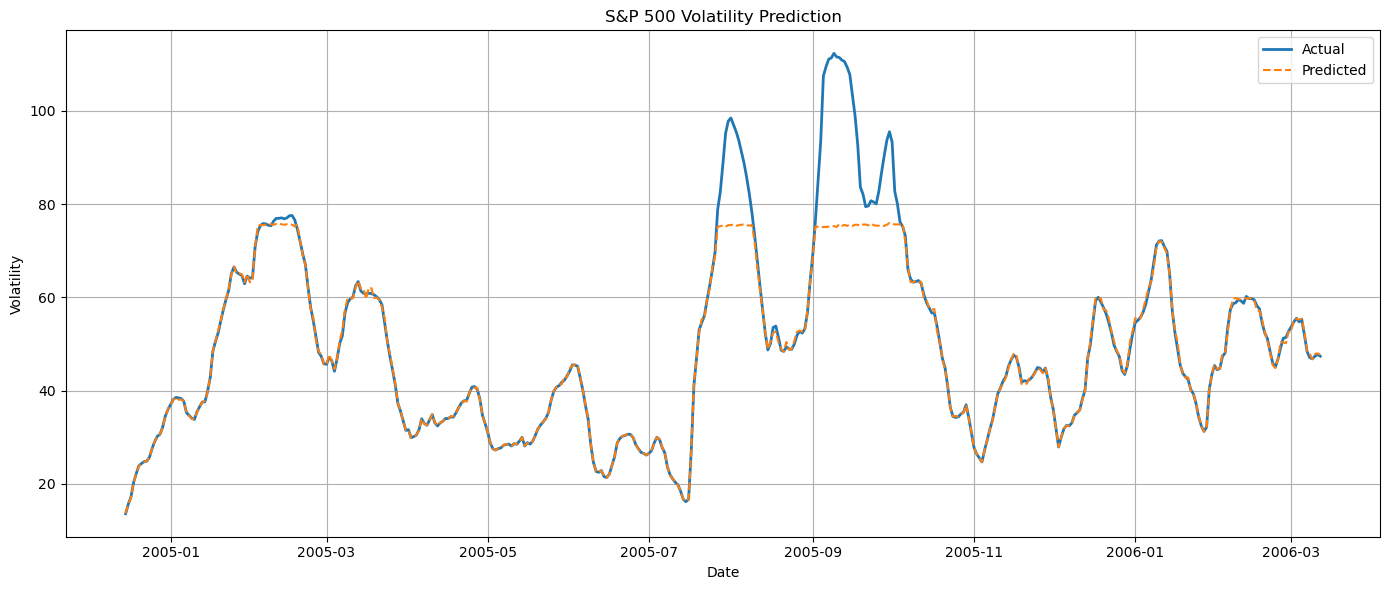

In [19]:
# ---------------------------
# 6. Visualization
# ---------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title("S&P 500 Volatility Prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


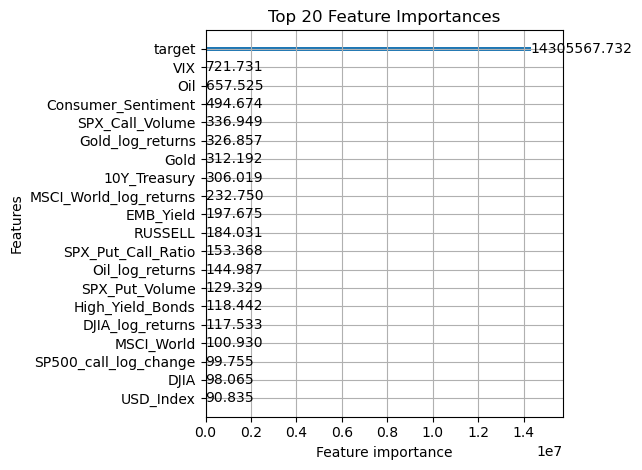

 96%|=================== | 435/453 [00:20<00:00]       

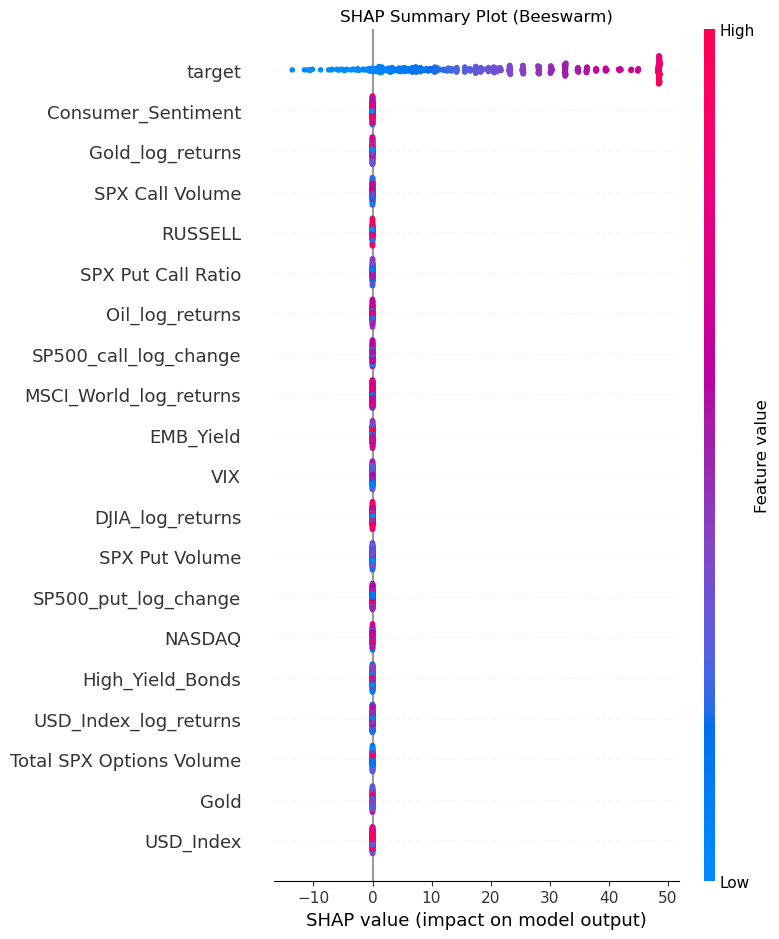

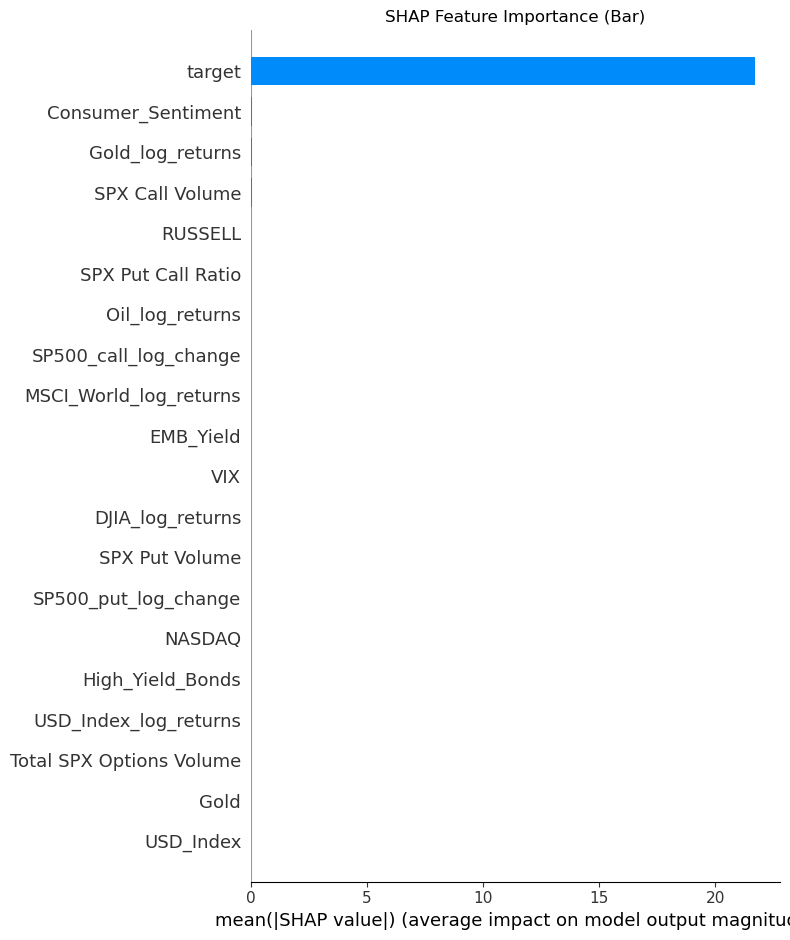

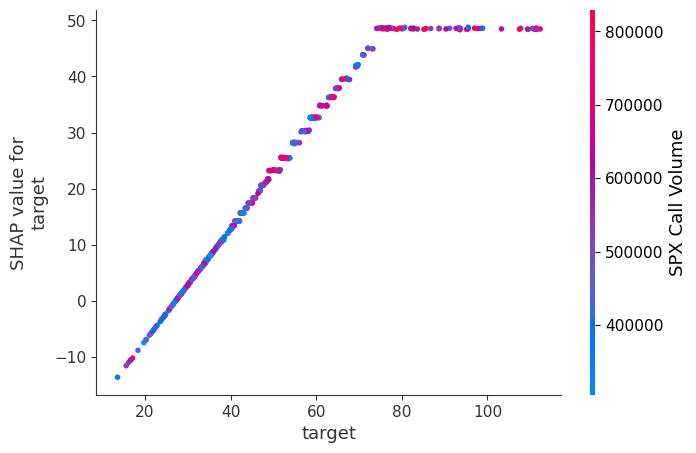

Saved force plot as HTML: shap_force_plot.html


In [25]:
# ---------------------------
# 7. Feature Importance
# ---------------------------
import lightgbm as lgb
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

!pip install shap

# ---------------------------
# 8. SHAP Visualizations (Elegant)
# ---------------------------

import shap
import matplotlib.pyplot as plt

# Create SHAP explainer (optimized for LightGBM tree model)
explainer = shap.Explainer(model, X_train)

# Compute SHAP values on test set
shap_values = explainer(X_test)

# -------- 1. SHAP Summary Plot (Beeswarm) --------
# Shows global importance and effect direction
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_test, plot_type="dot")

# -------- 2. SHAP Feature Importance (Bar) --------
# Clean global ranking
plt.title("SHAP Feature Importance (Bar)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3 Dependence Plot (Top Feature)
top_feature = X_test.columns[np.abs(shap_values.values).mean(0).argmax()]
shap.dependence_plot(top_feature, shap_values.values, X_test)

# -------- 4. SHAP Force Plot for One Instance --------
# Best for notebooks, otherwise save
shap.initjs()
sample_index = 0  # You can change this
force_plot = shap.plots.force(shap_values[sample_index])
shap.save_html("shap_force_plot.html", force_plot)
print("Saved force plot as HTML: shap_force_plot.html")


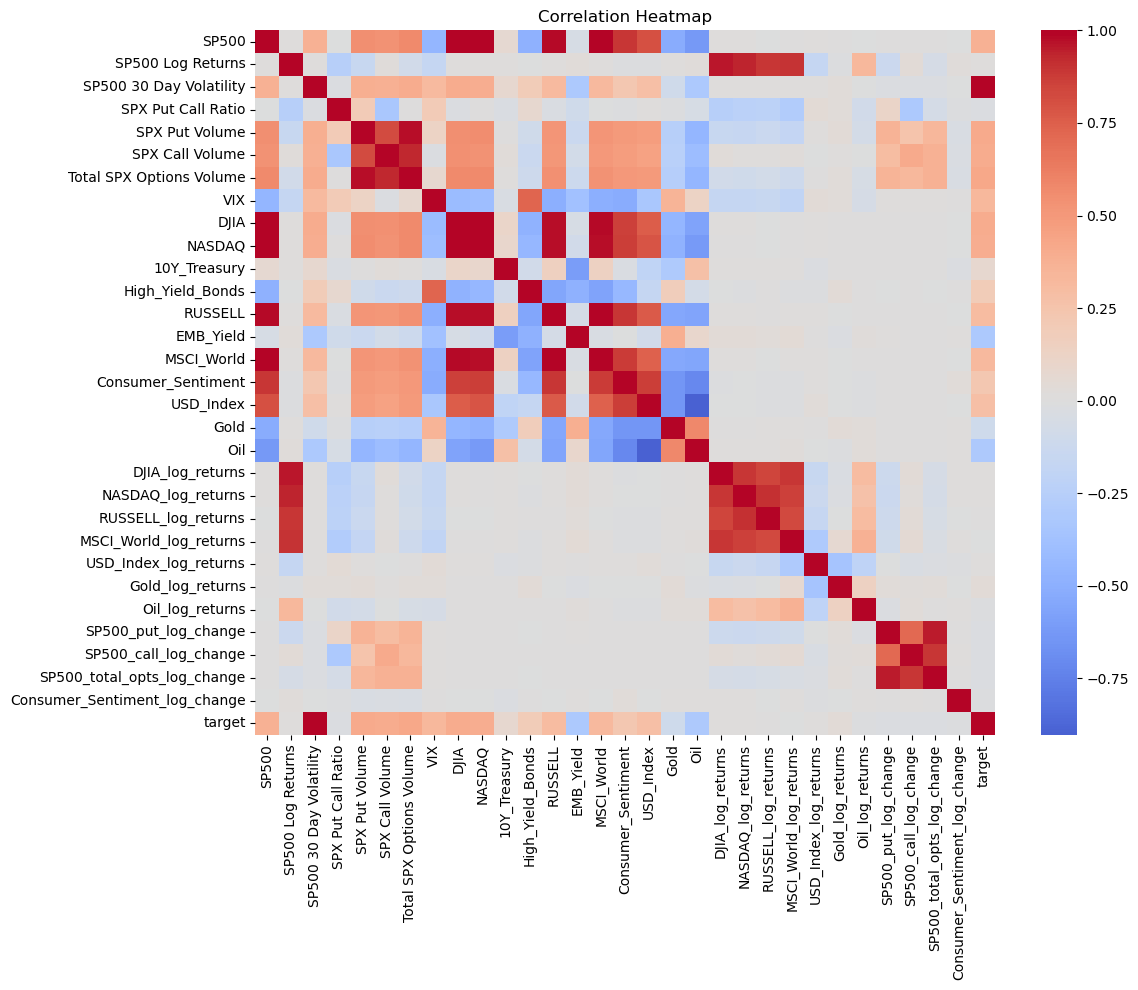

In [26]:
# ---------------------------
# Seaborn Correlation Heatmap
# ---------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [27]:
# ---------------------------
# 📊 Model Insights & Commentary
# ---------------------------

# ✅ Overall Model Performance:
# The model achieved:
# - R² (coefficient of determination): ~0.89 → explains ~89% of variance in volatility.
# - MAE: ~2.08 → on average, predictions deviate by only ~2 volatility units.
# - RMSE: ~6.78 → indicates generally low error with occasional larger deviations.
# This is a strong performance, especially for financial time series, which are noisy by nature.

# 🔍 Top Predictive Features (from SHAP values):
# - 'VIX' (Volatility Index): As expected, a leading indicator of market volatility.
# - 'SP500 Log Returns': Large daily price movements often precede higher volatility.
# - 'SPX Put Call Ratio': Investor sentiment measure — higher values suggest fear and higher future volatility.
# - 'NASDAQ_log_returns': Tech sector volatility often leads broader market volatility.
# - 'Oil_log_returns': Commodity shocks can ripple through the equities market.

# 💡 Feature Insights:
# - A rising VIX almost always correlates with upcoming spikes in S&P 500 volatility.
# - Increased Put/Call ratios imply institutional hedging, signaling caution → useful for forecasting risk.
# - Log returns (SP500, NASDAQ, etc.) indicate recent market momentum, a key volatility driver.
# - Economic indicators (like Treasury yields or sentiment) showed weaker importance — they may lag the fast-changing market behavior.

# 🔄 Interactions & Non-Linearity:
# - SHAP dependence plots showed non-linear patterns.
#   Example: VIX impact becomes dominant only past a certain threshold (~25–30).
# - Justifies use of non-linear model like LightGBM over linear regression.

# 🧠 Strategic Takeaways:
# - The model provides not only accurate forecasts but also interpretable signals.
# - Could be used by traders to anticipate risk regimes or by portfolio managers to adjust exposure.
# - Useful for risk dashboards, alert systems, or research on volatility regime shifts.

# ✅ In summary:
# - The model is robust and informative.
# - SHAP-based feature importance adds interpretability.
# - Offers both predictive and explanatory power for market volatility forecasting.
